# Combining all debates

This code combines the information of all the debates, and generates visualizations.

More importantly, it stores all the necessary information into pickle files, which are then used in other codes. It also removes all ambiguities in the data, i.e. the names of the same members, stated differently in different places are mapped to each other to avoid duplication.

The pickle files generated by this code are:

- member_names.pickle : Stores a list of the names of all the members in a specific order. This is used later to index members solely by their indices.



- edges.pickle : Stores the nodes and weights of all the edges in the graph i.e. a list of how many times each member has interacted with each other members.



- edge_details.pickle : Nested dictionaries of the following format:
    
    - (member1, member2) 
        - Debate 1
            - Timestamp 1
                - Keyword 1
                - Keyword 2
                - ...
            - Timestamp 2
                - ...
        - Debate 2
            - ...

- member_details.pickle : Stores a dictionary mapping each member to his/her constituency, party and the state they were elected from.

In [24]:
from bs4 import BeautifulSoup
import requests
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz
import numpy as np
import pickle
import pylab
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
import os
import operator
from math import cos, sin
from datetime import datetime
from collections import OrderedDict

%matplotlib inline

In [25]:
link = 'http://164.100.47.194/Loksabha/Debates/DebateAdvSearch15.aspx'
contents = requests.get(link).content
soup = BeautifulSoup(contents, 'html.parser')

In [26]:
types_of_debates = {}

records = soup.find('select', id = 'ContentPlaceHolder1_ddldebtype')
for option in records.find_all('option'):
    types_of_debates[option.text] = option['value']
    
types_of_debates.pop('--- Select Debate Type ---', None)

'--- Select Debate Type ---'

In [27]:
debate_graphs = {}
for key in types_of_debates:
    debate_graphs[key] = {}

In [28]:
files = os.listdir('../Data/Debates/')
debate_participants = {}
filtered_debates = set([])

for debate in types_of_debates:
    debate = debate.replace('/', ' ')
    try:
        f = open('../Data/Debates/' + debate + '.htm')
        filtered_debates.add(debate)
    except IOError:
        continue
    contents = f.read()
    soup = BeautifulSoup(contents, 'html.parser')
    f.close()
    records = soup.find_all('td')
    filtered_records = [rec.find_next_sibling('td') for rec in records if 'Participants:' in rec.text]
    filtered_records2 = [rec.find_next_sibling('td') for rec in records if 'Date:' in rec.text]
    filtered_records3 = [rec.find_next_sibling('td') for rec in records if 'Keywords:' in rec.text]
    count = 2
    while (debate + ' ' + str(count)) in files:
        f = open('../Data/Debates/' + debate + ' ' + str(count) + '.htm')
        contents = f.read()
        soup = BeautifulSoup(contents, 'html.parser')
        f.close()
        records = soup.find_all('td')
        filtered_records = filtered_records + [rec.find_next_sibling('td') for rec in records if 'Participants:' in rec.text]
        filtered_records2 = filtered_records2 + [rec.find_next_sibling('td') for rec in records if 'Date:' in rec.text]
        filtered_records3 = filtered_records3 + [rec.find_next_siblings('td') for rec in records if 'Keywords:' in rec.text]
        count += 1
    debate_participants[debate] = []
    for i in range(len(filtered_records)):
        rec = filtered_records[i]
        timestamp = datetime.strptime(filtered_records2[i].find('a').text.strip(), '%d-%m-%Y')
        keywords = filtered_records3[i].find_all('a')
        kw = set([])
        for k in keywords:
            kw.add(k.text.strip())
        current_participants = rec.find_all('a')
        debate_participants[debate].append([set([p.text.strip() for p in current_participants]), timestamp, kw])
        
types_of_debates = filtered_debates

# Storing the details of all members in dictionary member_details

In [29]:
f = open('../Data/members_of_parliament.htm')
contents = f.read()
f.close()
soup = BeautifulSoup(contents, 'html.parser')

table = soup.find('table', attrs = {'id' : 'ContentPlaceHolder1_tblMember'})
body = table.find('tbody')
table_of_contents = body.find_all('td')
table_of_contents = table_of_contents[6:]
members = []
for rec in table_of_contents:
    text = rec.text.strip().replace(',', ' ')
    text = text.split()
    if 'Shri' in text:
        text.remove('Shri')
    elif 'Smt.' in text:
        text.remove('Smt.')
    elif 'Dr.' in text:
        text.remove('Dr.')
    text = ' '.join(text).strip()
    members.append(text)
    
member_details = {}
n = len(members)

for i in range(0, n, 4):
    member_details[members[i]] = (members[i + 1], members[i + 2])

In [30]:
parties = []

for rec in member_details:
    if member_details[rec][0] not in parties:
        parties.append(member_details[rec][0])
    
len(parties)

39

# Mapping colours to parties

In [31]:
colors = ['#8b8378', '#cdb79e', '#ff4500', '#2f4f4f', '#191970', '#6495ed', '#7b68ee', '#00ffff', '#66cdaa', '#7fffd4', '#006400', '#556b2f', '#00ff7f', '#f0e68c', '#bdb76b', '#ffff00', '#daa520', '#b8860b', '#bc8f8f', '#f4a460', '#d2691e', '#b22222', '#4682b4', '#ff0000', '#ff1493', '#db7093', '#d02090', '#9932cc', '#d8bfd8', '#bebebe', '#0000ff', '#ff8c00', '#ffd700', '#e9967a', '#ffdead', '#ffffff','#ee8f8f', '#0b5670', '#fa8072']

color_map = {}

for i in range(len(parties)):
    color_map[parties[i]] = colors[i]

In [32]:
G = nx.Graph()
nodes = set([])

for debate in debate_participants:
    for rec in debate_participants[debate]:
        for p in rec[0]:
            text = p.split()
            if 'Shri' in text:
                text.remove('Shri')
            elif 'Smt.' in text:
                text.remove('Smt.')
            elif 'Dr.' in text:
                text.remove('Dr.')
            text = ' '.join(text)
            nodes.add(text)
        
nodes = list(nodes)

# Removing ambiguities in data by mapping inconsistent records

In [33]:
candidate_color = []
name_map = {'Sanjoy Takam':'Takam Sanjoy', 'Sivakumar @ J.K. Ritheesh. K':'Shivakumar K. alias J.K. Ritheesh', 'Singh Jagada Nand':'Singh Jagadanand',\
            'Kumari Putul':'Putul Kumari', 'Majhi Pradeep Kumar':'Majhi Pradeep', 'Taviad Prabha Kishore':'Taviad (Smt.) Prabha Kishor',\
            'J Helen Davidson':'Helen Davidson J.', 'Ponnam Prabhakar':'Prabhakar Ponnam', 'Hegde Anant Kumar':'Hegde Anantkumar', \
            'Patel Devji':'Patel Devji Mansingram', 'Ramshankar':'Ram Shankar Prof. (Dr.)', 'Bheiravdanji Gadhvi Mukeshkumar':'Gadhvi Mukesh Bhairavdanji',\
            'Ray Saugata':'Roy Prof. Saugata', 'Mithlesh':'Mithlesh Kumar', 'Singh Radhey Mohan':'Singh Radhe Mohan',\
            'Siddeswara Gowdar Mallikarjunappa':'Siddeshwara Gowdar Mallikarjunappa', 'Dastidar Kakli Ghosh':'Dastidar (Smt.) Kakoli Ghosh',\
            'Anandan M.':'Anandan K. Murugesan', 'Aaron Rashid J.M.':'Aaroon Rasheed J.M.', 'Pandey Saroj':'Pandey Km. Saroj',\
            'Vinay Kumar Alias Vinnu':'Pandey Vinay Kumar "Vinnu"', 'Gaddigoudar P.C.':'Gaddigoudar Parvatagouda Chandanagouda',\
            'Bhaiya Shivraj':'Lodhi Shivraj Singh', 'Baske Pulin Bihar':'Baske Pulin Bihari',\
            'Bapurao Khatgaonkar Patil Bhaskarrao':'Patil Bhaskarrao Bapurao', 'Swamygowda N Cheluvaraya Swamy @':'Swamy N. Chaluvaraya',\
            'Vivekanand G.':'Vivekanand Gaddam', 'Chaudhari Tusharbhai Amarsinhbhai':'Chaudhary Tushar Amarsinh', 'Antony A.K.':'Antony Anto',\
            'Naranbhai Kachhadia':'Kachhadiya Naranbhai Bhikhabhai', 'Singh Brij Bhushan Sharan':'Singh Brijbhushan Sharan',\
            'Lal Kirodi':'Meena Kirodilal', 'Gowda D.B. Chandre':'Gowda Chandre D.B.', 'Banerjee Kumari Mamata':'Banerjee Kum. Mamata',\
            'Sayeed Muhammed Hamdulla A. B.':'Sayeed Hamdullah', 'Krishnaswamy M.':'Krishnasswamy M.', 'Venugopal Danapal':'Venugopal Thiru Danapal',\
            'Rama Devi':'Devi Rama', 'Chanabasappa Udasi Shivkumar':'Udasi Shivkumar Chanabasappa', 'Botcha Lakshmi Jhansi':'Botcha (Smt.) Jhansi Lakshmi',\
            'Anuragi Ghansyam':'Anuragi Ghanshyam', 'Raju Pallam Mangapati Mallipudi':'Raju M. Mangapati Pallam', 'Singh Mahadev':'Khandela Mahadeo Singh',\
            'De Ratna':'De(Nag) (Smt.) Ratna', 'Rao Sambasiva Rayapati':'Rao Rayapati Sambasiva', 'Natrajan Meenakshi':'Natrajan Km. Meenakshi',\
            'Kashinath Taware Suresh':'Taware Suresh Kashinath', 'Venugopal P.':'Venugopal Ponnusamy', 'Kempegowda Suresh Doddaalahalli':'Suresh Doddaalahalli Kempegowda',\
            'Devi Aswamedh':'Devi Ashwamedh', 'Sukur Jadhav Baliram':'Jadhav Baliram Sukur', 'Beg Mirza Mehboob':'Beg (Dr.) Mirza Mehboob',\
            'Chowdhury Bansagopal':'Chowdhury Bansa Gopal', 'Mahajan Sumitra':'Sumitra Mahajan (Tai)',\
            'Narayanasamy V.':'Ramachandran Krishnan Narayanasamy', 'Thambidurai M.':'Thambi Durai M.', 'Thomas Prof. K.V.':'Thomas Prof. Kuruppassery Varkey',\
            'Agarwal Rajendra':'Agrawal Rajendra', 'Azad Kirti (Jha)':'Azad Kirti (JHA)', 'Pandurang Munde Gopinathrao':'Munde Gopinath Pandurang',\
            'Rathwa Ramsinhbhai Patalbhai':'Rathwa Ramsinh Pataliyabhai', 'Chauhan Mahendrasinh P.':'Chauhan Mahendrasinh Pruthvisinh',\
            'Deo Kalikesh Narayan Singh':'Singh Deo Kalikesh Narayan', 'Solanki Kirit Premjibhai':'Solanki (Prof.) Kirit Premjibhai', 'Haque Sk. Saidul':'Haque Prof. Sk. Saidul',\
            'Ajmal Badruddin':'Ajmal Maulana Badruddin', 'Sainuji Kowase Marotrao':'Kowase Marotrao Sainuji', 'Patel Lalubhai':'Patel Lalubhai Babubhai',\
            'Ray Rudramadhab':'Ray Rudra Madhab', 'Wakchaure Bhausaheb Rajaram':'Wakchaure Bhausaheb', 'Mohan Malik Sakti':'Malik Sakti Mohan', 'Biju P. K.':'Biju Parayamparambil Kuttappan',\
            'Kumar Ajay':'Kumar (Shri) Ajay', 'Jena Srikanta Kumar':'Jena Srikant Kumar', 'Chang C. M.':'Chang Chongshen Mongkosungkum', 'Guddu Premchandra':'Guddu Prem Chand',\
            'Rao Kalva Kuntla Chandrasekhar':'Rao Kalvakuntla Chandrashekar', 'Jeyadural S. R.':'Jeyadurai S. R.', 'Sahay Subodh Kant':'Sahai Subodh Kant',\
            'Nagorao Dudhgaonkar Ganeshrao':'Dudhgaonkar Ganeshrao Nagorao', 'Bajirao Patil Padamsinha':'Patil Padmasinha Bajirao', 'Harnsrajbhai Radadiya Vitthalbhai':'Radadiya Vitthalbhai Hansrajbhai',\
            'Prasad Kunwar Jitin':'Prasada Jitin', 'Veljibhai Jat Poonamben':'Jat Poonam Veljibhai', 'Bhujbal Sameer':'Bhujbal Sameer Magan', 'Sahu Chandulal Chandu Bhaiya':'Sahu Chandu Lal',\
            'Shetti Raju':'Shetti Raju alias Devappa Anna', 'Raghavendra B. Y.':'Yeddyurappa Raghavendra', 'Ju Dev Dilip Singh':'Judeo Dilip Singh',\
            'Speaker Protem (Manikrao Hodlya Gavit) Mr.':'Gavit Manikrao Hodlya', 'Das Gupta Gurudas':'Dasgupta Gurudas', 'Ganpatrao Jadhav Prataprao':'Jadhav Prataprao',\
            'Singh Sanjay':'Sinh Sanjay', 'Bapiraju Kanumuru':'Kanumuri Bapi Raju', 'Basheer E. T. Muhammed':'Basheer E. T. Mohammed', 'Sule Supriya':'Sule Supriya Sadanand',\
            'Deo V. Kishore Chandra S.':'Deo V. Kishore Chandra', 'Alagiri S.':'Alagiri Sambandam Keerapalayam', 'Abdulrahman':'Abdul Rahman', 'Paeethambarakurup N.':'Kurup N. Peethambara',\
            'Balram P.':'Naik Porika Balram', 'Anwar Tariq':'Choudhary Nikhil Kumar', 'Sudhakaran K.':'Sudhakaran Kumbakudi', 'Sinha Shatrughan':'Sinha Shatrughan Prasad',\
            'Rani Killi Krupa':'Killi (Smt.) Kruparani', 'Kataria Lal Chand':'Kataria Lalchand', 'Patil A.T. Nana':'Patil A.T. (Nana)', 'Vishwanath Katti Ramesh':'Katti Ramesh Vishwanath',\
            'Premdas':'Katheria Premdas', 'Roy Satabdi':'Roy (Banerjee) Satabdi', 'Vishwanath Adagur H':'Vishwanath Adagooru Huchegowda', 'Adsul Anandrao Vithoba':'Adsul Anandrao',\
            'Singh Bhupendra':'Singh Bhoopendra', 'Sangma Km. Agatha K.':'Sangma Kum. Agatha K.', 'Yadav Hukamdeo Narayan':'Yadav Hukmdev Narayan', 'Dharmshi Babar Gajanan':'Babar Gajanan Dharmshi',\
            'Dashmunsi Deepa':'Dasmunsi Deepa', 'Singh Jitender':'Malik Jitender Singh', 'Nishad Capt.(Retd.) Jainarayan Prasad':'Nishad Capt.(Retd.) Jainarain Prasad',\
            'Thol Thirumaavalavan':'Thol Thirumaa Valavan', 'Preneet Kaur':'Kaur Preneet', 'Singh Baba K.C.':'Baba K.C. Singh', 'Chavan Harischandra Deoram':'Chavan Harishchandra Deoram',\
            'Ola Sheesh Ram':'Ola Sis Ram', 'Nirupam Sanjay Brijkishorilal':'Nirupam Sanjay', 'Shinde Sushil Kumar':'Shinde Sushil Kumar Sambhajirao', 'Hegde K. Jayaprakash':'Hegde Jayaprakash Korgi',\
            'Khattri Nirmal':'Khatri Nirmal', 'Yadav Ranjan Prasad':'Yadav Prof. Ranjan Prasad', 'Bajwa Partap Singh':'Bajwa Sardar Partap Singh', 'Rawat Harish Chandra Singh':'Rawat Harish',\
            'Pratapsinhmaharaj Bhonsle Shrimant Chh. Udganraje':'Bhonsle Udayanraje Pratapsingh', 'Viswanathan P.':'Perumal Viswanathan', 'Singh Sukhdev':'Libra Sukhdev Singh',\
            'Aron Praveen Singh':'Aron Praveen Singh.', 'Gawali Patil Bhavana Pundlikrao':'Bhawana Gawali (Patil) Ms.', 'Gangaram Awale Jaywant':'Awale Jayawant Gangaram', 'Singh Gopal':'Shekhawat Gopal Singh',\
            'Singh Alias Pappu Singh Uday':'Singh Uday', 'Singh Kunwar Ratanjeet Pratap Narayan':'Singh Ratanjit Pratap Narain', 'Shankar Alias Kushal Tiwari Bhisma':'Tiwari Bhismshankar Alias Kushal',\
            'Virendra Kumar':'Kumar Virendra', 'Bavalia Kuvarjibhai Mohanbhai':'Bavaliya Kunwarjibhai Mohanbhai', 'Mirdha Jyoti':'Mirdha (Smt.) Jyoti', 'Dhanaplan K. P.':'Dhanapalan K. P.',\
            'Rana (Raju Rana) Rajendrasinh Ghanshyamsinh':'Rana Rajendrasinh (Raju Rana)', 'Haque Mohammad Asrarul':'Mohammad Asrarul Haque', 'Vasava Mansukhbhai D.':'Vasava Mansukhbhai Dhanjibhai',\
            'Jaiswal Shriprakash':'Jaiswal Sriprakash', 'Panda Baijayant':'Panda Baijayant "Jay"'}
            
redundant_nodes = []
    
for rec in nodes:
    if rec in member_details:
        candidate_color.append(color_map[member_details[rec][0]])
        name_map[rec] = rec
    elif rec in {'Gill M.S.', 'Deshmukh Vilasrao', 'Ramesh Jairam', 'Fernandes Oscar', 'Azad Ghulam Nabi', 'Krishna S.M.', 'Roy Mukul', 'Secretary-General', 'Natchiappan DR. E. M. Sudarsana', 'Chiranjeevi K.', 'Shukla Rajeev', 'Soni Ambika', 'Khan K. Rahman', 'Vasan G. K.', 'Seelam Jesudasu', 'Chavan Prithviraj', 'Natarajan Shrimati Jayanthi', 'Singh Manmohan', 'Ravi Vayalar', 'Kumar Ashwani', 'Sharma Anand'}:
        name_map[rec] = rec
        member_details[rec] = ('INC', 'Rajya Sabha')
        candidate_color.append(color_map[member_details[name_map[rec]][0]])
    elif rec in name_map:
        member_details[rec] = member_details[name_map[rec]]
        redundant_nodes.append(name_map[rec])
        candidate_color.append(color_map[member_details[rec][0]])
    else:
        print(rec)
    
nodes = [name_map[rec] for rec in nodes]

# Forming the dictionary storing the information of all the edges and making the names of members uniform across debates

The most important step here is the formation of edge_labels, which stores the main information about the interactions between members i.e. how many times, and in what types of debates they interacted with each other.

Edge labels format: Dictionary of dictionaries of dictionaries

(member1, member2) -> {days they interacted on -> set of keywords in their interactions}

Here, we also create a new dictionary debate_details, which is the same as debate_participants, except that it contains the mapped names of the members, thus leading to uniform data in all stored pickle files.

In [34]:
edge_weights = {}
edge_labels = {}
time_data = {}
debate_details = {}

for debate in debate_participants:
    debate_details[debate] = []
    for rec in debate_participants[debate]:
        debate_members = set([])
        for p1 in rec[0]:
            text1 = p1.split()
            if 'Shri' in text1:
                text1.remove('Shri')
            elif 'Smt.' in text1:
                text1.remove('Smt.')
            elif 'Dr.' in text1:
                text1.remove('Dr.')
            text1 = ' '.join(text1)
            debate_members.add(name_map[text1])
            for p2 in rec[0]:
                if p1 == p2:
                    continue
                text2 = p2.split()
                if 'Shri' in text2:
                    text2.remove('Shri')
                elif 'Smt.' in text2:
                    text2.remove('Smt.')
                elif 'Dr.' in text2:
                    text2.remove('Dr.')
                text2 = ' '.join(text2)
                
                if (name_map[text1], name_map[text2]) in edge_weights:
                    edge_weights[(name_map[text1], name_map[text2])] += 0.5 # 0.5 because each edge will be encountered twice
                    if debate in edge_labels[(name_map[text1], name_map[text2])]:
                        if rec[1] in edge_labels[(name_map[text1], name_map[text2])][debate]:
                            edge_labels[(name_map[text1], name_map[text2])][debate][rec[1]] |= set(rec[2])
                        else:
                            edge_labels[(name_map[text1], name_map[text2])][debate][rec[1]] = set(rec[2])
                    else:
                        edge_labels[(name_map[text1], name_map[text2])][debate] = {rec[1] : set(rec[2])}
                elif (name_map[text2], name_map[text1]) in edge_weights:
                    edge_weights[(name_map[text2], name_map[text1])] += 0.5
                    if debate in edge_labels[(name_map[text2], name_map[text1])]:
                        if rec[1] in edge_labels[(name_map[text2], name_map[text1])][debate]:
                            edge_labels[(name_map[text2], name_map[text1])][debate][rec[1]] |= set(rec[2])
                        else:
                            edge_labels[(name_map[text2], name_map[text1])][debate][rec[1]] = set(rec[2])
                    else:
                        edge_labels[(name_map[text2], name_map[text1])][debate] = {rec[1] : set(rec[2])}
                else:
                    edge_weights[(name_map[text1], name_map[text2])] = 0.5
                    edge_labels[(name_map[text1], name_map[text2])] = {}
                    edge_labels[(name_map[text1], name_map[text2])][debate] = {rec[1] : set(rec[2])}
        debate_details[debate].append([debate_members, rec[1], rec[2]])
                

# Ordering the edges so that edges of the form (i, j) and (j, i) collapse into (i, j) if i < j and (j, i) otherwise.

In [35]:
edges = []
nodes = set([])
index = -1
member_index = {}
member_names = []
edge_data = {}

for e in edge_weights:
    if e[0] not in member_names:
        member_names.append(e[0])
        index += 1
        member_index[index] = e[0]
        nodes.add(index)
    if e[1] not in member_names:
        member_names.append(e[1])
        index += 1
        member_index[index] = e[0]
        nodes.add(index)
    edges.append((min(member_names.index(e[0]), member_names.index(e[1])), max(member_names.index(e[0]), member_names.index(e[1])), int(edge_weights[e])))
    
for e in edge_labels:
    edge_data[(min(member_names.index(e[0]), member_names.index(e[1])), max(member_names.index(e[0]), member_names.index(e[1])))] = {}
    for debate in edge_labels[e]:
        edge_data[(min(member_names.index(e[0]), member_names.index(e[1])), max(member_names.index(e[0]), member_names.index(e[1])))][debate] = edge_labels[e][debate]
                         
                         
                         

In [36]:
edges = sorted(edges, key=operator.itemgetter(2), reverse = True)

In [37]:
for e in edges:
    G.add_edge(e[0], e[1], weight=e[2])

In [38]:
legend_list = []

for i in range(len(parties)):
    legend_list.append(mpatches.Patch(color = colors[i], label = parties[i]))
    
fontp = FontProperties()
fontp.set_size('small')

# Rendering the graph using networkx

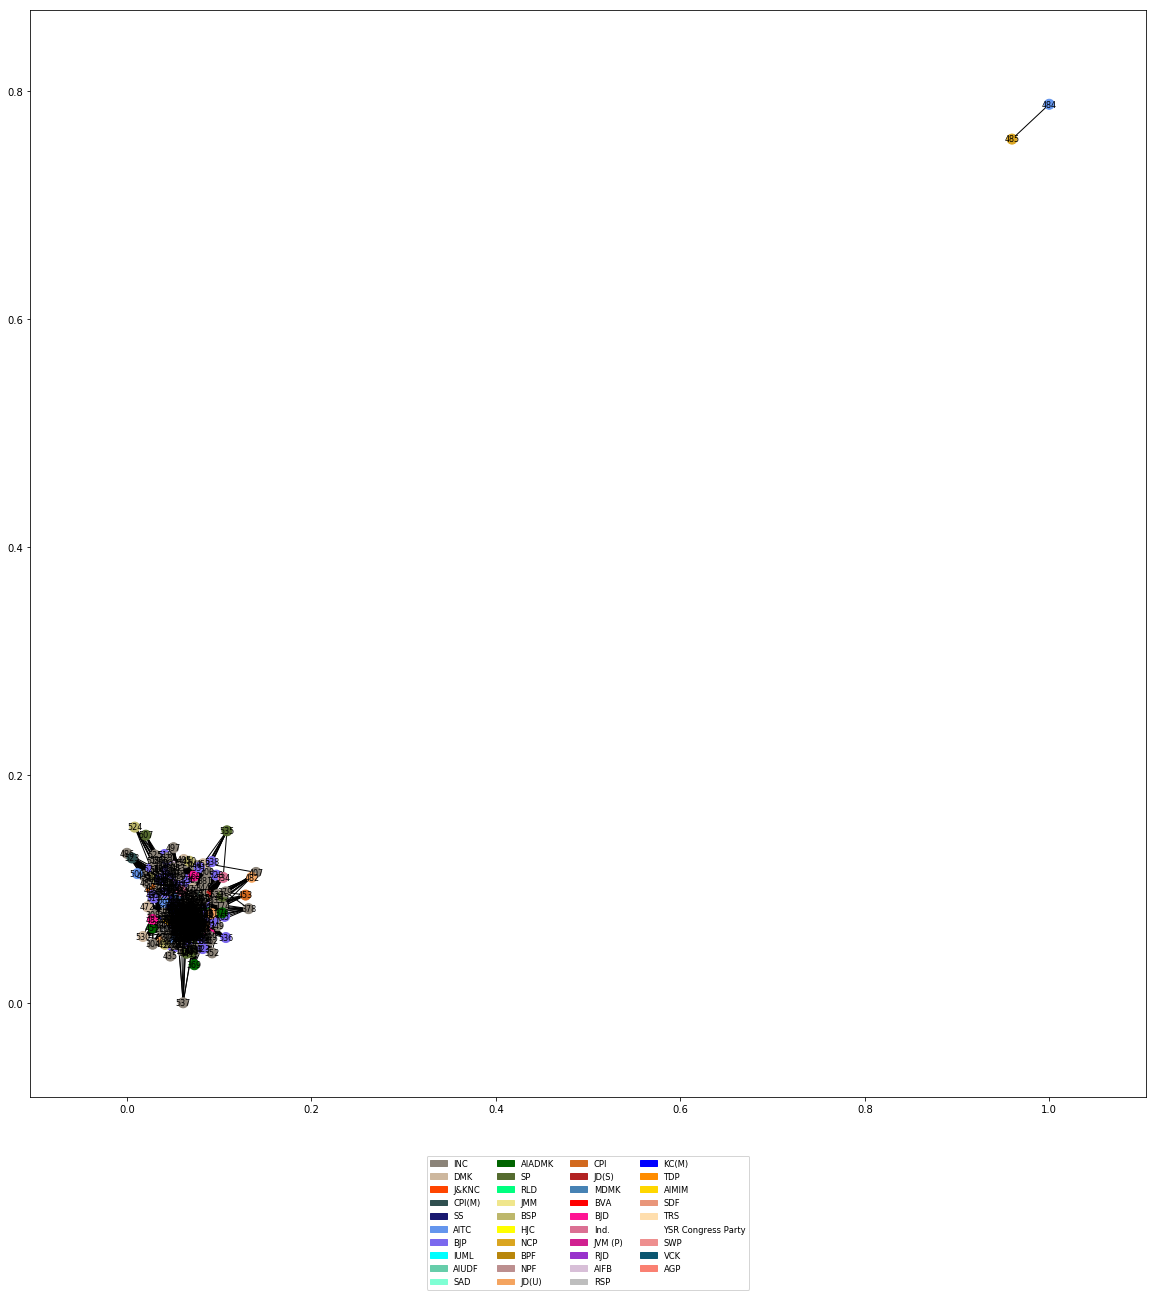

In [39]:
count = 1


pos = nx.fruchterman_reingold_layout(G)

pylab.figure(1, figsize = (20, 20))
nx.draw_networkx(G, pos, with_labels = True, node_color = candidate_color, node_size = 100, font_size = 8, dim = 3)
plt.legend(handles = legend_list, loc = 'upper center', bbox_to_anchor = (0.5, -0.05), prop = fontp, ncol = 4)

#nx.draw_graphviz(G, with_labels = True, layout = 'random_layout')
plt.savefig('../Results/Graphs/interaction_graph_' + str(count) + '.png')
count += 1

# Rendering the graph for a particular member, as the previous one isn't easy to understand.

Here, the distance between the desired member node and its neighbours is inversely proportional to the level of interaction between them.

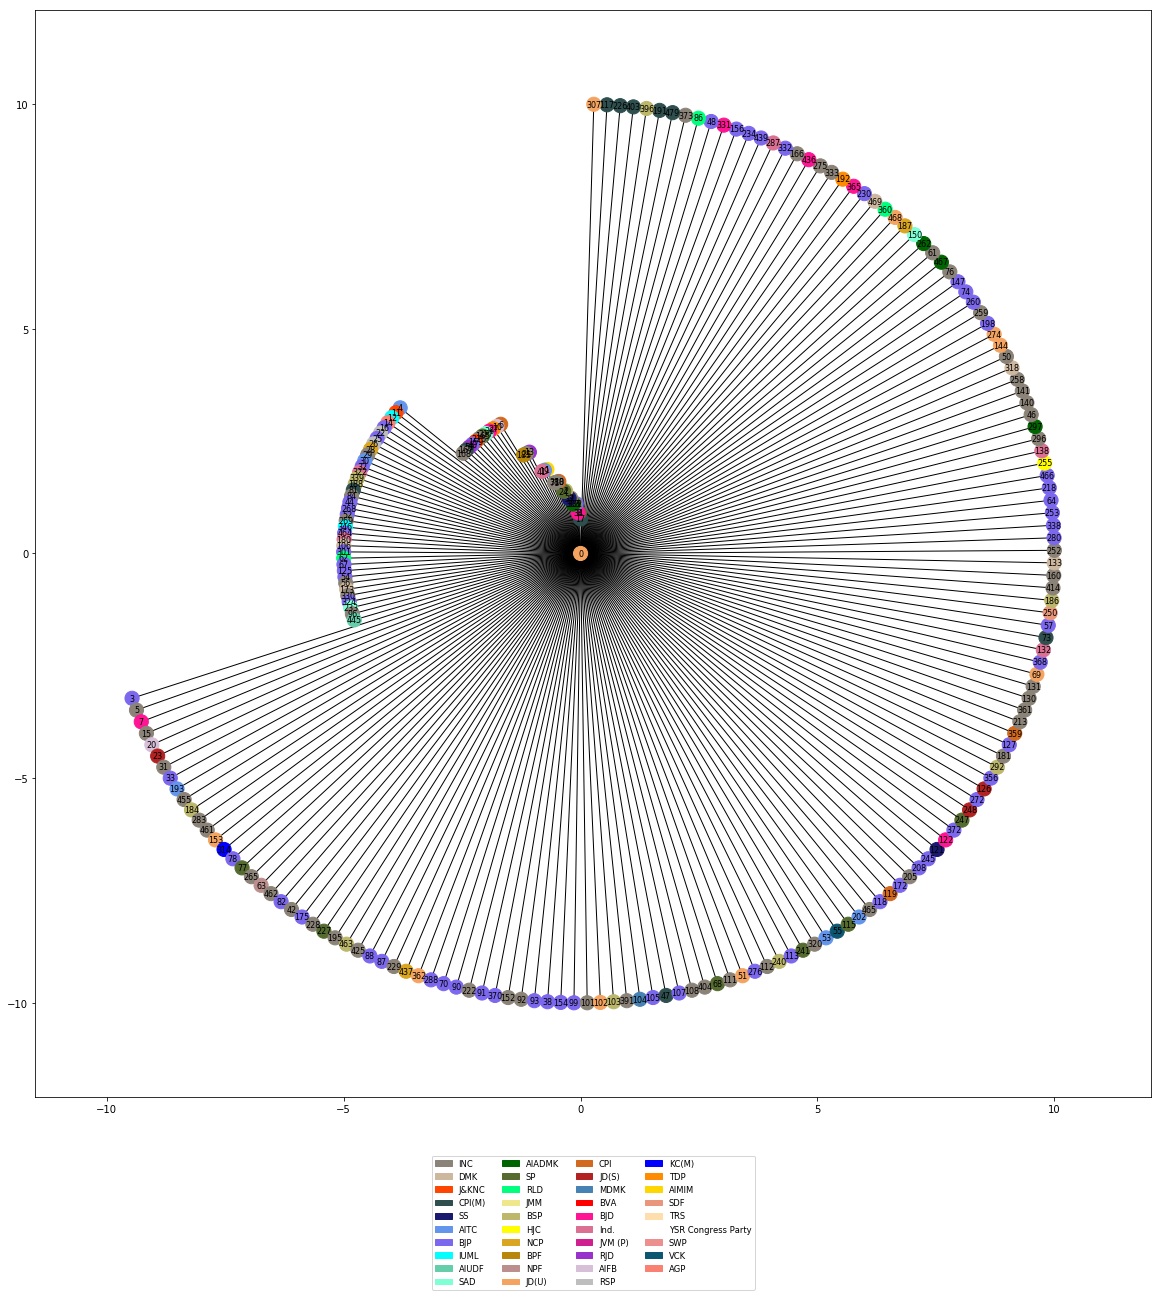

In [40]:
H = G.subgraph([0])

neighbours = G[0]

for n in neighbours:
    H.add_edge(0, n, weight=neighbours[n]['weight'])

pos = {0 : (0, 0)}

delta = 2 * np.pi / len(G[0])
theta = np.pi / 2

candidate_colors = []

for n in neighbours:
    pos[n] = ((10.0 / neighbours[n]['weight']) * cos(theta), (10.0 / neighbours[n]['weight']) * sin(theta))
    theta += delta
    candidate_colors.append(color_map[member_details[member_names[n]][0]])

pylab.figure(1, figsize = (20, 20))
nx.draw_networkx(H, pos, with_labels = True, node_size = 200, font_size = 8, node_color = candidate_colors)
plt.legend(handles = legend_list, loc = 'upper center', bbox_to_anchor = (0.5, -0.05), prop = fontp, ncol = 4)

#nx.draw_graphviz(H, with_labels = True, prog='sfdp')
plt.savefig('../Results/Graphs/member_' + str(1) + '.png')


# Finding 15 most popular keywords

In [41]:
keywords = {}

for debate in debate_participants:
    for rec in debate_participants[debate]:
        for kw in rec[2]:
            if kw == '':
                continue
            if kw in keywords:
                keywords[kw] += 1
            else:
                keywords[kw] = 1
                
keywords = OrderedDict(sorted(keywords.items(), key=operator.itemgetter(1), reverse = True))

# Writing the lists and dictionaries to pickle files for use in other codes

In [42]:
f = open('../Results/Pickles/member_names.pickle', 'wb')
pickle.dump(member_names, f)
f.close()

In [43]:
f = open('../Results/Pickles/edges.pickle', 'wb')
pickle.dump(edges, f)
f.close()

In [44]:
f = open('../Results/Pickles/edge_details.pickle', 'wb')
pickle.dump(edge_data, f)
f.close()

In [45]:
for rec in redundant_nodes:
    del member_details[rec]

f = open('../Results/Pickles/member_details.pickle', 'wb')
pickle.dump(member_details, f)
f.close()

In [46]:
f = open('../Data/parties.csv', 'w')

for i in range(len(parties)):
    f.write(parties[i] + '\n')
    
f.close()

In [47]:
f = open('../Results/Pickles/keyword_frequencies.pickle', 'wb')
pickle.dump(keywords, f)
f.close()

In [48]:
f = open('../Results/Pickles/debate_details.pickle', 'wb')
pickle.dump(debate_details, f)
f.close()